# Images used for the cover PhD thesis 
In this notebook, we read the important data to create the images used to create the cover of the PhD Thesis. First, we import the Python packages.

In [1]:
import sphviewer

import astropy.units as u
from astropy.table import Table, hstack, join

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

## Standard Plot Format
Setup the standard plotting format and make the plot.

In [2]:
# graphic aspect ratio = width/height
ASPECT = 8.0/8.0

# Text width in inches - don't change, this is defined by the print layout
TEXTWIDTH = 5.14  # inches

# output format and resolution
FIG_FMT = 'pdf'
DPI = 300

# Graphic dimensions
PLT_W = DPI*TEXTWIDTH
PLT_H = PLT_W/ASPECT
AX_FONTSIZE = 10
LAB_FONTSIZE = 8
LWIDTH = 0.5
AX_PAD = 3
WINCHES = TEXTWIDTH
HINCHES = WINCHES/ASPECT

# LaTeX is used throughout for markup of symbols, Times-Roman serif font
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif',
       'serif': ['Times-Roman'], 'weight': 'bold', 'size': '16'})

# Font and line weight defaults for axes
matplotlib.rc('axes', linewidth=LWIDTH)
matplotlib.rcParams.update({'font.size': AX_FONTSIZE})

# axis and label padding
plt.rcParams['xtick.major.pad'] = f'{AX_PAD}'
plt.rcParams['ytick.major.pad'] = f'{AX_PAD}'
plt.rcParams['axes.labelpad'] = f'{AX_PAD}'

## Retrieve data
We retrieve the data from a given galaxy and read their gas a stars data from the estimates.

In [3]:
GALID = 45 # I choose the 45 because it is clear to put in edge-on and face-on

In [4]:
def read_gas_data(gal_id):
    """Read the gas data from a given Galaxy ID and calculate the total gas luminosity of [C II]"""
    gas = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(gal_id)+'.hdf5',
                     format='hdf5', path='Gas')
    gas_l = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(gal_id)+'.hdf5',
                       format='hdf5', path='GasnTL')
    gmc = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(gal_id)+'.hdf5',
                     format='hdf5', path='GMC')
    gmc_l = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(gal_id)+'.hdf5',
                       format='hdf5', path='GMCnTL')
    rgas = hstack([gas, gas_l])
    rgmc = hstack([gmc, gmc_l])
    sum_gmc = rgmc.group_by('ParentSPH').groups.aggregate(np.sum)
    sum_gmc.rename_column('ParentSPH', 'ParticleIDs')
    sph_all = join(rgas, sum_gmc, keys='ParticleIDs', join_type='left')
    sph_all['LCII'] = (sph_all['ICII_Lato'] +
                       sph_all['ICII_Lmol'] +
                       sph_all['ICII_Ldiff'])
    return sph_all

def read_stars_data(gal_id):
    """Read the stars data for a given Galaxy ID."""
    stars = Table.read('../../EAGLE/z0_Recal/ProcessedFITS/Gal' + str(gal_id)+'.hdf5',
                       format='hdf5', path='Stars')
    sum_stars = stars.group_by(['CoordX',
                                'CoordY',
                                'CoordZ']).groups.aggregate(np.sum)
    return sum_stars

In [5]:
data_gas = read_gas_data(GALID)
data_stars = read_stars_data(GALID)

In [6]:
pos_gas = np.array([(data_gas['CoordX_1']*u.cm).to(u.kpc).value,
                    (data_gas['CoordY_1']*u.cm).to(u.kpc).value,
                    (data_gas['CoordZ_1']*u.cm).to(u.kpc).value])
pos_stars = np.array([(data_stars['CoordX']*u.cm).to(u.kpc).value,
                      (data_stars['CoordY']*u.cm).to(u.kpc).value,
                      (data_stars['CoordZ']*u.cm).to(u.kpc).value])

In [7]:
positions = [pos_gas, pos_gas, pos_gas, pos_stars]
mass_ato = data_gas['ICII_Lato']
mass_mol = data_gas['ICII_Lmol']
mass_dig = data_gas['ICII_Ldiff']
mass_HII = data_stars['ICII_LHII']
mass_HII[np.isnan(mass_HII)] = 0
masses = [mass_ato, mass_mol, mass_dig, mass_HII]
Cmaps = ['Oranges_r', 'Greens_r', 'Blues_r', 'Reds_r']

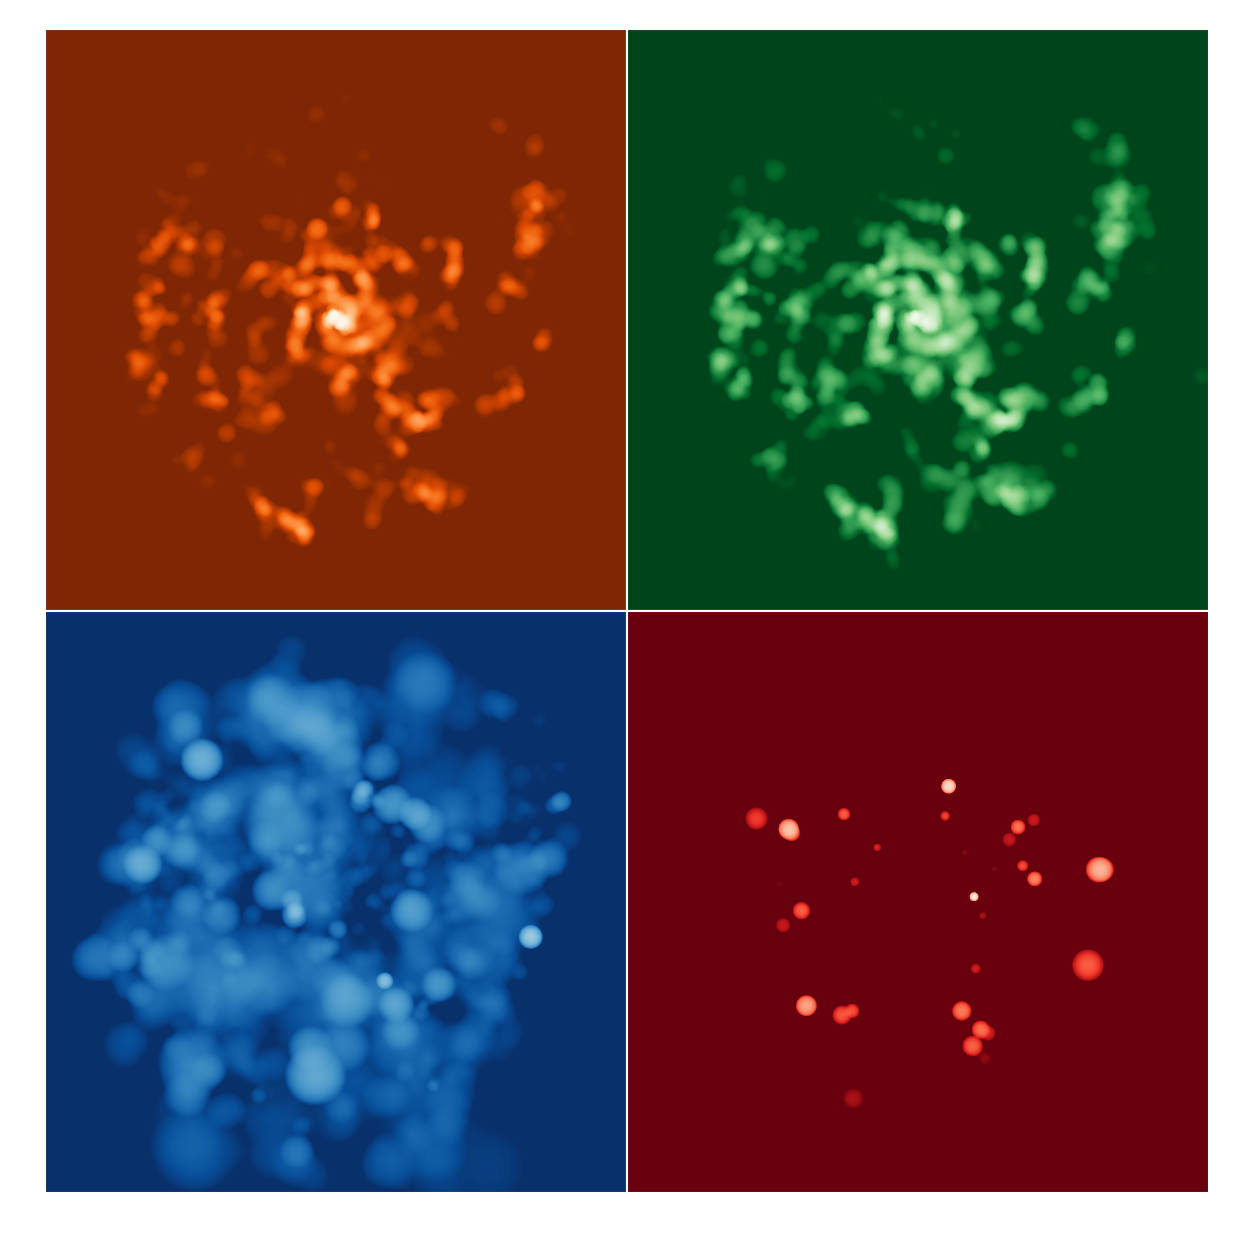

In [8]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_dpi(DPI)
fig.set_size_inches(WINCHES, HINCHES)
axs = axs.ravel()
imtot = []
for type_par in range(4):
    particles = sphviewer.Particles(positions[type_par].T, masses[type_par])
    scene = sphviewer.Scene(particles)
    scene.update_camera(r=33)  # 33 work good
    scene.update_camera(p=18, t=52, roll=90, xsize=2000, ysize=2000)
    render = sphviewer.Render(scene)
    render.set_logscale()
    img = render.get_image()
    imtot.append(img)
    extent = render.get_extent()
    axs[type_par].imshow(img, origin='lower',
                         cmap=Cmaps[type_par], vmin=2, vmax=5)
    plt.setp(axs[type_par].get_yticklabels(), visible=False)
    plt.setp(axs[type_par].get_xticklabels(), visible=False)
    axs[type_par].set_xticks([])
    axs[type_par].set_yticks([])
    axs[type_par].set_aspect('equal')
    axs[type_par].spines[:].set_color('white')
# axs[0].set_ylabel('Edge-on view')
# axs[2].set_ylabel('Face-on view')
# axs[0].set_title('SPH Gas')
# axs[1].set_title('SPH Stars')
plt.subplots_adjust(wspace=0, hspace=0, left=0.035, right=0.79)
plt.savefig('../Figures/Cover/Phases'+str(GALID)+'.pdf', bbox_inches='tight',
            facecolor='white')  # For Paper

In [9]:
for type_par in range(4):
    particles = sphviewer.Particles(positions[type_par].T, masses[type_par])
    scene = sphviewer.Scene(particles)
    scene.update_camera(r=33)  # 33 work good
    scene.update_camera(p=18, t=52, roll=90, xsize=2000, ysize=2000)
    render = sphviewer.Render(scene)
    render.set_logscale()
    img = render.get_image()
    extent = render.get_extent()
    imtot.append(img)
    plt.imsave('../Figures/Cover/Type'+str(type_par)+'.png', img, origin='lower', dpi=300,
               #               cmap='magma', vmin=1.5, vmax=5.5)
               cmap=Cmaps[type_par], vmin=1.5, vmax=5.5)
#     plt.setp(axs[type_par].get_yticklabels(), visible=False)
#     plt.setp(axs[type_par].get_xticklabels(), visible=False)
#     plt.set_xticks([])
#     axs[type_par].set_yticks([])
#     axs[type_par].set_aspect('equal')
#     axs[type_par].spines[:].set_color('white')

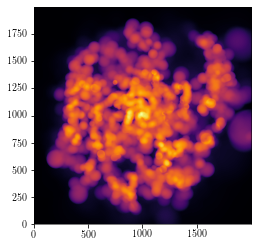

In [10]:
plt.imshow(np.nanmedian(imtot, axis=0),
           origin='lower',
           cmap='inferno')
plt.imsave('../Figures/Cover/Typeall.png', np.nansum(imtot, axis=0),
           origin='lower', dpi=300,
           cmap='inferno')

## Blending
Although I run some experiments to create better and more "interesting" images, not all of them where used. In any case, this and following code are left here as a reference.

In [11]:
# from sphviewer.tools import Blend
# import matplotlib.cm as cml

In [12]:
# def get_normalized_image(image, vmin=None, vmax=None):
#     if(vmin == None):
#         vmin = np.min(image)
#     if(vmax == None):
#         vmax = np.max(image)
#     image = np.clip(image, vmin, vmax)
#     image = (image-vmin)/(vmax-vmin)
#     return image

In [13]:
# rgb_ato  = cml.Oranges_r(get_normalized_image(imtot[0], 0, 10))
# rgb_mol  = cml.Greens_r(get_normalized_image(imtot[1], 0, 10))
# rgb_dig  = cml.Blues_r(get_normalized_image(imtot[2], 0, 10))
# rgb_hii  = cml.Reds_r(get_normalized_image(imtot[3], 0, 10))

In [14]:
# blend1 = Blend.Blend(rgb_ato, rgb_mol)
# blend2 = Blend.Blend(rgb_dig, rgb_hii)

In [15]:
# output1 = blend1.Screen()
# output2 = blend2.Screen()
# blend3 = Blend.Blend(output1, output2)
# output3 = blend3.Screen()


In [16]:
# plt.imshow(output3, cmap='magma')

## Temporal code
This temporal code is to test and create videos of the projections.

In [17]:
# import os
# import cv2

In [18]:
# def video_creation(data, pos, name, cmap, vmin, vmax):
#     image_folder = 'temporal_images'
#     data[np.isnan(data)] = 0
#     mass = data
#     particles = sphviewer.Particles(pos.T, mass)
#     scene = sphviewer.Scene(particles)
#     scene.update_camera(r=33)  # 33 work good
#     for p in range(360):
#         scene.update_camera(p=p, t=52)
#         render = sphviewer.Render(scene)
#         render.set_logscale()
#         img = render.get_image()
#         extent = render.get_extent()
#         plt.imsave(image_folder+'/snap_'+name+'%03d.png' % p,
#                    img, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
#     print('Done creating '+name+' images')
#     video_name = 'video_'+name+'.avi'

#     images = ['snap_'+name+'%03d.png' % i for i in range(360)]
#     frame = cv2.imread(os.path.join(image_folder, images[0]))
#     height, width, layers = frame.shape

#     video = cv2.VideoWriter(video_name, 0, 40, (width, height))

#     for image in images:
#         video.write(cv2.imread(os.path.join(image_folder, image)))

#     cv2.destroyAllWindows()
#     video.release()
#     print('Done creating '+name+' video')

In [19]:
# video_creation(data_gas['ICII_Lato'], pos_gas, 'ato', 'Oranges_r', 2.5, 5.5)

In [20]:
# video_creation(data_gas['ICII_Ldiff'], pos_gas, 'diff', 'Blues_r', 2.5, 5.5)

In [21]:
# video_creation(data_stars['ICII_LHII'], pos_stars, 'HII', 'Reds_r', 2.5, 5.5)

##### Notebook information

In [22]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy   : 5.0
numpy     : 1.22.1
matplotlib: 3.4.3
sphviewer : 1.2.4
json      : 2.0.9
autopep8  : 1.5.7

Watermark: 2.2.0

